In [167]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  7 11:24:13 2024

@author: mrsag
"""

import yt
import numpy as np
import matplotlib.pyplot as plt
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from scipy.signal import fftconvolve
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.path import Path
from skimage import io
from skimage.transform import resize

import matplotlib as mpl


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=100 # highres display

In [168]:

def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index

def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal

In [169]:
class polygon_plate():
    def __init__(self, vertices, potential=0):
        """
        vertices: list of (x, y) points (scaled between 0 and 1)
        potential: potential value inside the polygon
        """
        if len(vertices) < 3:
            raise ValueError("A polygon must have at least 3 vertices.")

        if vertices[0] != vertices[-1]:
            vertices.append(vertices[0])

        self.vertices = vertices
        self.potential = potential
 

class simulationbox2d():
    def __init__(self, resolution_x=300, resolution_y=300,
                b_y0=0, b_x0=0, b_y1=0, b_x1=0,
                potential_offset=0, match_boundary=True, potential_given_on_boundary=False):
        
        
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y
        self.xx, self.yy = np.mgrid[0:1:resolution_x*1j, 0:1:resolution_y*1j]
        self.potential = np.zeros_like(self.xx) + potential_offset

        def resample_boundary(boundary, target_length):
            if isinstance(boundary, (int, float)) and boundary == 0:
                return np.zeros(target_length)
            boundary = np.array(boundary)
            x_old = np.linspace(0, 1, len(boundary))
            x_new = np.linspace(0, 1, target_length)
            return np.interp(x_new, x_old, boundary)

        # Resample all boundaries
        self.b_y0 = resample_boundary(b_y0, resolution_y)  # bottom (y = 0)
        self.b_y1 = resample_boundary(b_y1, resolution_y)  # top    (y = 1)
        self.b_x0 = resample_boundary(b_x0, resolution_x)  # left   (x = 0)

        # Apply delta offset to b_y0 and b_y1 to match b_x0 ends
        delta_y0 = self.b_x0[0] - self.b_y0[0]
        delta_y1 = self.b_x0[-1] - self.b_y1[0]
        self.b_y0 += delta_y0
        self.b_y1 += delta_y1

        # Final right edge boundary: interpolate or keep at zero
        if match_boundary:
            self.b_x1 = np.linspace(self.b_y0[-1], self.b_y1[-1], resolution_x)
        else:
            self.b_x1 = np.zeros(resolution_x)

        # Apply boundary values to potential grid
        self.potential[:, 0] = self.b_x0  # x = 0 (left)
        self.potential[:, -1] = self.b_x1  # x = 1 (right)
        self.potential[0, :] = self.b_y0  # y = 0 (bottom)
        self.potential[-1, :] = self.b_y1  # y = 1 (top)
        
        self.fixed_mask = np.zeros_like(self.potential, dtype=bool)

        if potential_given_on_boundary:
            self.fixed_mask[:, 0] = True   # x = 0
            self.fixed_mask[:, -1] = True  # x = 1
            self.fixed_mask[0, :] = True   # y = 0
            self.fixed_mask[-1, :] = True  # y = 1



    def add_polygon_plate(self, plate: polygon_plate):
        points = np.vstack((self.yy.ravel(), self.xx.ravel())).T  # (x, y) order
        path = Path(plate.vertices)

        mask_inside = path.contains_points(points)

        eps = 1e-6
        path_buffered = Path(np.array(plate.vertices) * (1 + eps))
        mask_edge = path_buffered.contains_points(points)

        mask = np.logical_or(mask_inside, mask_edge)
        mask = mask.reshape(self.xx.shape)

        self.potential[mask] = plate.potential
        self.fixed_mask[mask] = True




    def add_disk_plate(self, center, radius, potential=0):
        """
        Adds a circular plate of fixed potential to the simulation grid.

        Parameters:
        - center: (x, y) coordinates of the center of the disk (in normalized 0–1 space)
        - radius: radius of the disk (in normalized 0–1 space)
        - potential: potential value inside the disk
        """
        cx, cy = center
        dist_squared = (self.xx - cx) ** 2 + (self.yy - cy) ** 2
        mask = dist_squared <= radius ** 2
        self.potential[mask] = potential
        self.fixed_mask[mask] = True



    def add_image(self, image, threshold=0.5, potential=0):
        """
        Adds a fixed potential region based on a grayscale image mask.

        Parameters:
        - image_path: path to the image file
        - threshold: normalized threshold (0–1) for deciding potential region
        - potential: potential value to assign above threshold
        """
        
        # Resize to match simulation resolution
        image=np.flip(image,axis=0)
        threshold /= np.max(image)
        resized_image = resize(image, (self.resolution_x, self.resolution_y), anti_aliasing=True)

        # Create mask where intensity > threshold
        mask = resized_image > threshold

        # Apply potential and fix those positions
        self.potential[mask] = potential
        self.fixed_mask[mask] = True



    def solve(self, max_iter=10000, tol=1e-5, method='gauss-seidel', verbose=False):
        V = self.potential.copy()
        fixed = self.fixed_mask

        for it in range(max_iter):
            V_old = V.copy()
            converged = True

            if method == 'jacobi':
                updated = 0.25 * (
                    V_old[1:-1, 2:] + V_old[1:-1, :-2] +
                    V_old[2:, 1:-1] + V_old[:-2, 1:-1]
                )
                mask = ~fixed[1:-1, 1:-1]
                V[1:-1, 1:-1][mask] = updated[mask]

            elif method == 'gauss-seidel':
                for i in range(self.resolution_x):
                    for j in range(self.resolution_y):
                        if not fixed[i, j]:
                            # Safe neighbor access with boundary reflection
                            up    = V[i+1, j] if i + 1 < self.resolution_x else V[i, j]
                            down  = V[i-1, j] if i - 1 >= 0 else V[i, j]
                            right = V[i, j+1] if j + 1 < self.resolution_y else V[i, j]
                            left  = V[i, j-1] if j - 1 >= 0 else V[i, j]
                            V[i, j] = 0.25 * (up + down + right + left)

            else:
                raise ValueError("Method must be 'jacobi' or 'gauss-seidel'")

            # Convergence check
            diff = np.max(np.abs(V - V_old))
            if verbose and it % 500 == 0:
                print(f"Iter {it}: max change = {diff:.2e}")
            if diff < tol:
                if verbose:
                    print(f"Converged after {it} iterations.")
                break

        self.potential = V


            

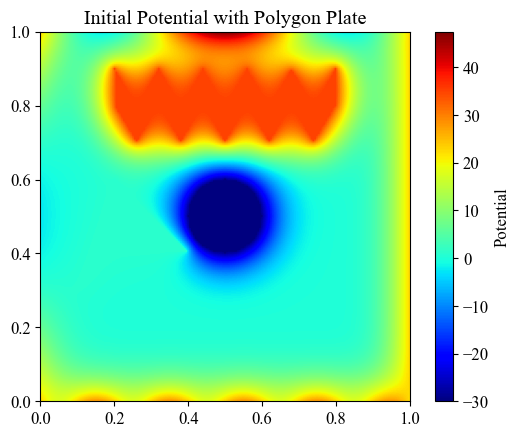

In [170]:
plate1 = polygon_plate(
    vertices=[(0.1, 0.3), (0.2, 0.6), (0.4, 0.4), (0.2, 0.4)],
    potential=1
)

# Create alternating zigzag points
x_plate2 = list(np.linspace(0.2, 0.8, 11))  # Use odd number for clean pairing
y_plate2 = 0.8*np.ones(len(x_plate2))
y_plate2[::2] +=0.1
x_plate2.extend(x_plate2[::-1])
y_plate2_bottom = list(y_plate2[::-1]-0.1)
y_plate2 = list(y_plate2)
y_plate2.extend(y_plate2_bottom)

# Top zigzag path
vertices_plate2 = [(x_plate2[i], y_plate2[i]) for i in range(len(x_plate2))]

# Now you can create the polygon plate
plate2 = polygon_plate(vertices=vertices_plate2, potential=35)

b_y0 = -5*np.sin(np.linspace(0,31.4159,100))
b_x0 = 1*np.linspace(-5,5,100)**2-0.1*25
b_y1 = -25*np.sin(np.linspace(0,3*3.14159,100))

sim = simulationbox2d(201, 201, b_y0=b_y0, b_x0 = b_x0, b_y1 = b_y1, match_boundary=True, potential_given_on_boundary=True)
sim.add_polygon_plate(plate1)
sim.add_polygon_plate(plate2)
sim.add_disk_plate(center=(0.5,0.5),radius=0.1,potential=-30)
sim.solve(max_iter=200)

plt.imshow(sim.potential, origin='lower', cmap="jet",extent=[0,1,0,1])
plt.colorbar(label='Potential')
plt.title("Initial Potential with Polygon Plate")
plt.show()


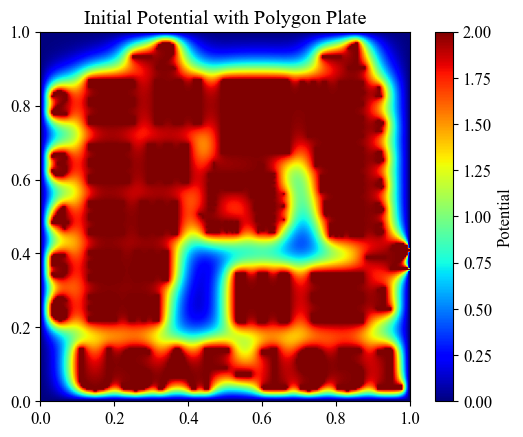

In [173]:
# b_y0 = -5*np.sin(np.linspace(0,31.4159,100))
# b_x0 = 1*np.linspace(-5,5,100)**2-0.1*25
# b_y1 = -25*np.sin(np.linspace(0,3*3.14159,100))

image = io.imread(r"D:\temporary backup\Codes\lab codes\Diffraction pattern\USAF-1951.png")
image = image[:,:,1]

sim = simulationbox2d(201, 201,potential_given_on_boundary=True)
sim.add_image(image,threshold=100,potential=2)
sim.solve(max_iter=100)

plt.imshow(sim.potential, origin='lower', cmap="jet",extent=[0,1,0,1])
plt.colorbar(label='Potential')
plt.title("Initial Potential with Polygon Plate")
plt.show()


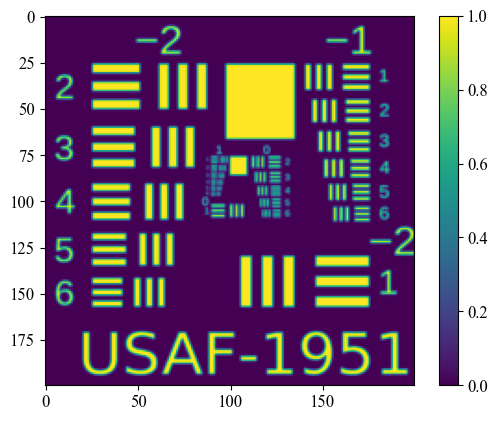

In [172]:
image = io.imread(r"D:\temporary backup\Codes\lab codes\Diffraction pattern\USAF-1951.png")
image = image[:,:,1]
image = resize(image,(200,200))

plt.imshow(image)
plt.colorbar()
plt.show()